In [8]:
# %% Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import openmesh_data_converter as odc

print("✓ Imports loaded")

✓ Imports loaded


In [53]:
# %% Load Data

# CML dataset
ds_nyc = xr.open_dataset("data/temp/OpenMesh_cur.nc")

# Metadata
df_metadata = pd.read_csv("data/temp/links_metadata_cur.csv")

# Weather data:

import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

weather_data = odc.load_weather_data(
    weather_base_path="data/weather/",
    print_output=False
)

print(f"✓ Loaded: {ds_nyc.sizes['cml_id']} CMLs, {ds_nyc.sizes['time']} timesteps")

✓ Loaded: 103 CMLs, 354241 timesteps


In [7]:
ds_nyc

<xarray.Dataset> Size: 149MB
Dimensions:       (time: 354241, sublink_id: 1, cml_id: 103)
Coordinates:
  * time          (time) datetime64[ns] 3MB 2023-10-29 ... 2024-07-01
  * cml_id        (cml_id) int32 412B 1 2 3 4 5 6 7 ... 97 98 99 100 101 102 103
    site_0_lat    (cml_id) float64 824B ...
    site_0_lon    (cml_id) float64 824B ...
    site_1_lat    (cml_id) float64 824B ...
    site_1_lon    (cml_id) float64 824B ...
    length        (cml_id) float64 824B ...
    polarization  (sublink_id, cml_id) object 824B ...
    frequency     (sublink_id, cml_id) int32 412B ...
  * sublink_id    (sublink_id) object 8B 'sublink_1'
Data variables:
    rsl           (time, sublink_id, cml_id) float32 146MB ...
Attributes:
    title:                 OpenMesh
    file_author_s:         Dror Jacoby
    institution:           WiMNet Lab, Columbia University; CellEnMon Lab, Te...
    date:                  2025-04-23
    source:                NYC Community Mesh Network: https://www.nycmesh.net/
    history:               2025-04-23: cleaned CSV → OpenSense-1.1 NetCDF FOR...
    naming_convention:     OpenSense-1.1
    license_restrictions:  CC BY 4.0 – https://creativecommons.org/licenses/b...
    reference:             https://github.com/drorjac/OpenMesh
    comment:               Prepared for paper ‘OpenMesh: Wireless Signal Data...

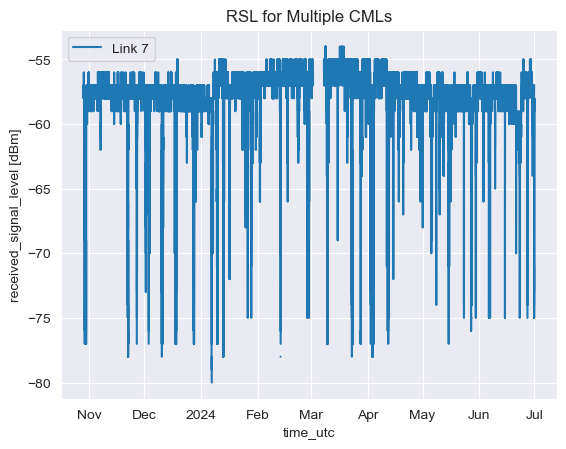

In [73]:


# Plot RSL for multiple CMLs
cml_ids = [7]

for cml_id in cml_ids:
    ds_nyc.rsl.sel(cml_id=cml_id, sublink_id='sublink_1').plot(label=f'Link {cml_id}')
plt.legend()
plt.title('RSL for Multiple CMLs');

In [57]:
# Convert weather DataFrame time to UTC
def convert_weather_to_utc(df, from_timezone='America/New_York'):
    """
    Convert weather DataFrame index from local time to UTC

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with datetime index in local time
    from_timezone : str
        Source timezone (default: 'America/New_York')

    Returns
    -------
    pandas.DataFrame
        DataFrame with UTC time index
    """
    import pytz

    # Localize to NYC time then convert to UTC
    # Use 'NaT' to mark ambiguous times as NaT (DST transitions)
    df_utc = df.copy()
    try:
        df_utc.index = df_utc.index.tz_localize(from_timezone, ambiguous='NaT', nonexistent='shift_forward').tz_convert('UTC')
        # Drop NaT rows if any
        df_utc = df_utc[df_utc.index.notna()]
    except:
        # Fallback: assume UTC if conversion fails
        print(f"Warning: Could not convert timezone, assuming UTC")

    return df_utc

# Create UTC version of weather data
weather_data_utc = {}
for source in ['airports', 'noaa', 'pws']:
    weather_data_utc[source] = {}
    for key in weather_data[source].keys():
        weather_data_utc[source][key] = convert_weather_to_utc(weather_data[source][key])

# Also copy metadata (no time conversion needed)
weather_data_utc['metadata'] = weather_data['metadata']

print("✓ Created weather_data_utc (UTC time)")
print("✓ Original weather_data (NYC time) preserved")

✓ Created weather_data_utc (UTC time)
✓ Original weather_data (NYC time) preserved


In [31]:
weather_data['pws']['precip'].head()

,KNYNEWYO1805,KNYNEWYO1288,KNYNEWYO1238,KNYNEWYO1622,KNYNEWYO1796,KNYNEWYO1747,KNYNEWYO1626,KNYNEWYO1533,KNYNEWYO1867,KNYNEWYO1896,...,KNYNEWYO1024,KNYNEWYO1053,KNYNEWYO1651,KNYNEWYO1824,KNYNEWYO1900,KNYNEWYO1918,KNYNEWYO1921,KNYNEWYO1931,KNYNEWYO1943,KNYNEWYO1942
2023-10-29 00:00:00,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-29 00:05:00,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-29 00:10:00,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-29 00:15:00,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-29 00:20:00,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


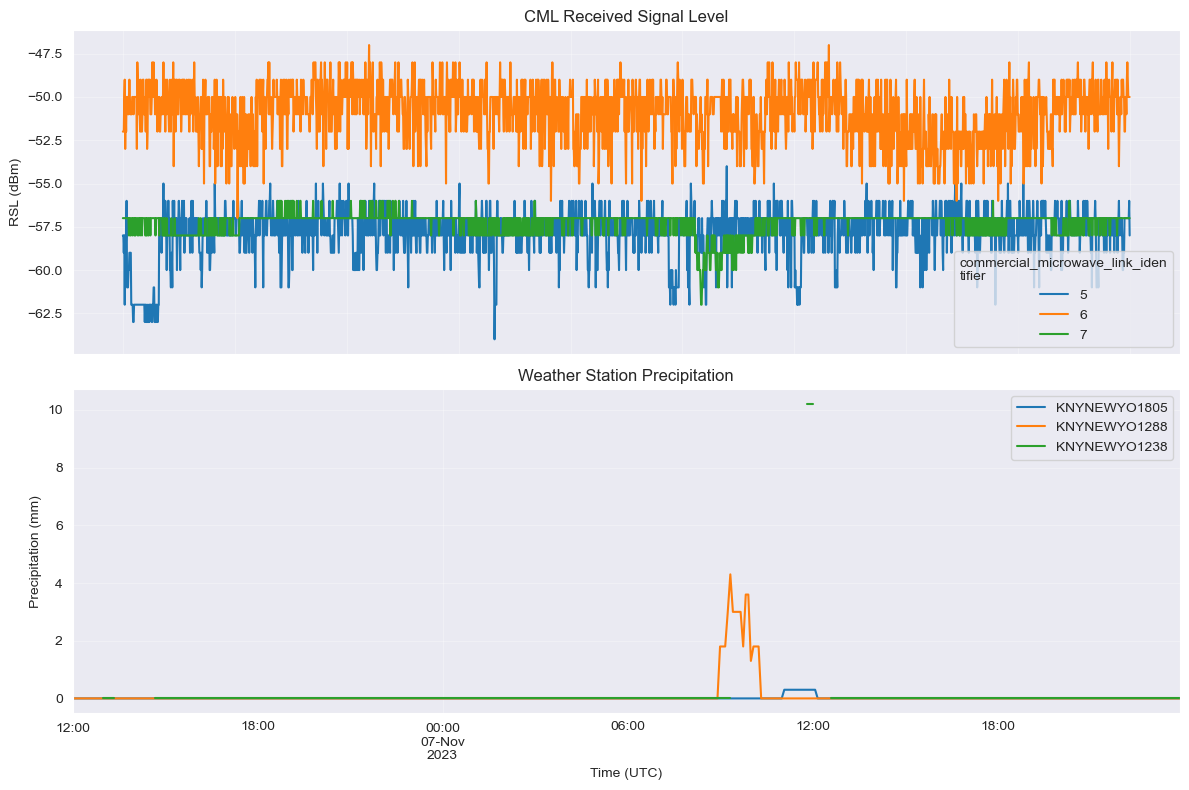

In [71]:
# Plot CMLs and Weather for same time period
cml_ids = [ 5,6,7 ]
weather_stations = ['KNYNEWYO1805', 'KNYNEWYO1288', 'KNYNEWYO1238']
time_slice = slice('2023-11-06 12:00', '2023-11-07')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Top: CML RSL
ds_nyc.rsl.sel(cml_id=cml_ids, sublink_id='sublink_1', time=time_slice).plot.line(
    x='time',
    hue='cml_id',
    ax=ax1
)
ax1.set_title('CML Received Signal Level')
ax1.set_ylabel('RSL (dBm)')
ax1.set_xlabel('')  # Remove x-label from top plot
ax1.tick_params(labelbottom=False)  # Hide x-tick labels on top plot
ax1.grid(True, alpha=0.3)

# Bottom: Weather precipitation
weather_data_utc['pws']['precip'].loc[time_slice, weather_stations].plot(ax=ax2)
ax2.set_title('Weather Station Precipitation')
ax2.set_ylabel('Precipitation (mm/h)')
ax2.set_xlabel('Time (UTC)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout();